## Imports

In [8]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
#!pip install torchio

import tensorflow as tf
#for neuroimaging data
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os



In [9]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory


In [10]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [11]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name()} for inference' if torch.cuda.is_available() else 'Using CPU for inference')

Using NVIDIA GeForce RTX 3060 Laptop GPU for inference


## Dataset 

In [12]:
root_dir = 'Dataset'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri = tio.ScalarImage(file_path),
                )
                dataset.append(subject)
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

print('First Image Dimensions in Dataset: ')
print(dataset[0].spatial_shape)


Number of Images in Dataset: 777
First Image Dimensions in Dataset: 
(256, 200, 256)


## Import Labels

In [13]:
# check if a file named participants.tsv exists in the each of the subfolder under the root directory
# If it exists, load the file and display the contents
for subdir in subdirectories:
    if os.path.exists(os.path.join(subdir, 'participants.csv')):
        print('Found participants.tsv in ' + subdir)
        df = pd.read_csv(os.path.join(subdir, 'participants.csv'), sep=',', header=0)

for subject in dataset:
    adhd_label = df['dx'].values[0]
    if adhd_label != 'Typically Developing Children':
        adhd_label = 'ADHD'
    subject['adhd'] = adhd_label

Found participants.tsv in Dataset\KKI
Found participants.tsv in Dataset\NeuroIMAGE
Found participants.tsv in Dataset\NYU
Found participants.tsv in Dataset\OHSU
Found participants.tsv in Dataset\Peking_1
Found participants.tsv in Dataset\Peking_2
Found participants.tsv in Dataset\Peking_3


## Image Preprocessing

In [14]:
transforms = [
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomAffine(),
    tio.RandomBiasField(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.CropOrPad((256, 256, 256)),
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(dataset, transform=transform)
print(len(subjects_dataset))

777


ADHD Label: Typically Developing Children


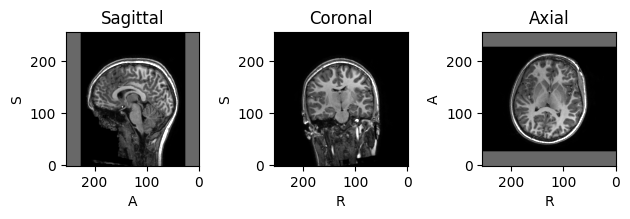

(256, 256, 256)
ADHD Label: Typically Developing Children


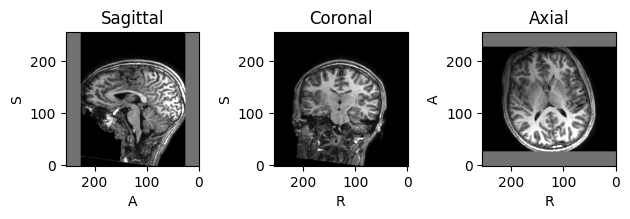

(256, 256, 256)
ADHD Label: Typically Developing Children


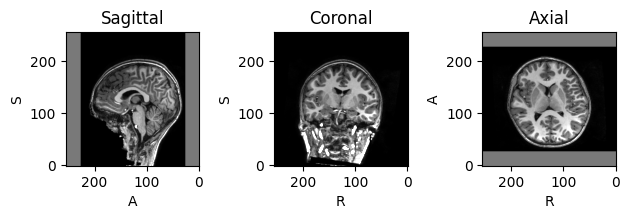

(256, 256, 256)
ADHD Label: Typically Developing Children


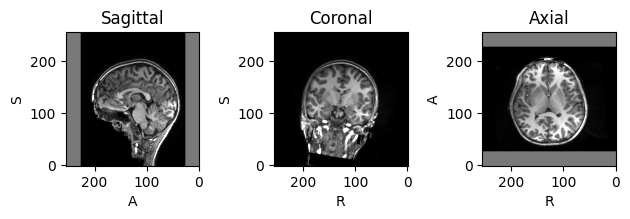

(256, 256, 256)
ADHD Label: Typically Developing Children


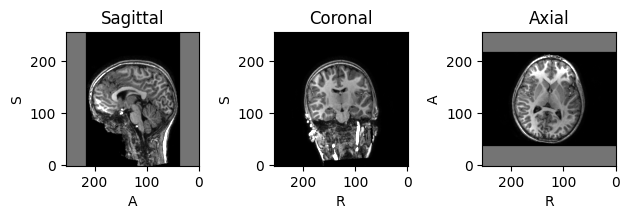

(256, 256, 256)


In [15]:
#Shows the preprocessed images
for i in range(5):
    subject = subjects_dataset[i]
    image = subject['mri']
    print('ADHD Label: ' + subject['adhd'])
    image.plot()
    plt.show()
    print(subjects_dataset[i]['mri'].spatial_shape)

## Train/Test Split

In [16]:
# split the torchio dataset into train/test with a 80/20 ratio
n = len(subjects_dataset)
n_train = int(0.8 * n)
n_val = n - n_train
train_dataset, val_dataset = torch.utils.data.random_split(subjects_dataset, [n_train, n_val])

# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# Create a DataLoader for the validation dataset
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

# Print the number of batches in the training and validation loaders
print('Number of Batches in Training Loader: ' + str(len(train_loader)))

print('Number of Batches in Validation Loader: ' + str(len(val_loader)))



Number of Batches in Training Loader: 156
Number of Batches in Validation Loader: 39


## Pre-Trained Model

In [17]:
import torch
import torchvision.models as models

# Load the pre-trained CNN model for neuorimaging data
model = models.efficientnet_v2_s(pretrained=True)
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the model architecture
print(model)
model = model.to(device)



c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
# Set the model to training mode
model.train()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the device
model = model.to(device)

# Iterate over the batches in the training loader
for batch_idx, batch_data in enumerate(train_loader):
    # Get the input data and target labels from the batch
    input_data = batch_data['mri']['data'][:, :3, :, :].to(device)  # Exclude the channel dimension
    target_labels = batch_data['adhd']
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    output = model(input_data)
    
    # Compute the loss
    loss = criterion(output, target_labels)
    
    # Backward pass
    loss.backward()
    
    # Update the model parameters
    optimizer.step()
    
    # Print the loss for each batch
    print('Batch: {}, Loss: {:.6f}'.format(batch_idx, loss.item()))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [4, 1, 256, 256, 256]